# setting

## libraries 

In [1]:
import gc 
import numpy as np 
import pandas as pd 
import xgboost as xgb 
from tqdm.notebook import tqdm 

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## defining functions 

**SMAPE**
- $\text{SMAPE}=\dfrac{100\%}{n} \sum\limits_{t=1}^{n} \dfrac{F_t - A_t}{(|A_t|+|F_t|)/2}$

In [2]:
def smape_lst(y_true, y_pred) : 
    smap = np.zeros(len(y_true)) 
    
    num = np.abs(y_true - y_pred) 
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true != 0) | (y_pred != 0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

def smape_value(y_true, y_pred) : 
    smap = np.zeros(len(y_true)) 
    
    num = np.abs(y_true - y_pred) 
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true != 0) | (y_pred != 0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [4]:
!ls dataset 

census_starter.csv
sample_submission.csv
test.csv
train.csv


In [5]:
BASE = 'dataset/'

In [6]:
census = pd.read_csv(BASE + 'census_starter.csv')
print(census.columns) 
census.head()

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [7]:
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')
print(train.shape, test.shape, sub.shape)

train['istest'] = 0 
test['istest'] = 1 

(122265, 7) (25080, 3) (25080, 2)


In [8]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,0


In [9]:
test.head()

,row_id,cfips,first_day_of_month,istest
0,1001_2022-11-01,1001,2022-11-01,1
1,1003_2022-11-01,1003,2022-11-01,1
2,1005_2022-11-01,1005,2022-11-01,1
3,1007_2022-11-01,1007,2022-11-01,1
4,1009_2022-11-01,1009,2022-11-01,1


In [10]:
pd.concat((train, test)).sort_values(['cfips', 'row_id']).reset_index(drop = True)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0
...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,NaN,NaN,2023-02-01,NaN,NaN,1
147341,56045_2023-03-01,56045,NaN,NaN,2023-03-01,NaN,NaN,1
147342,56045_2023-04-01,56045,NaN,NaN,2023-04-01,NaN,NaN,1
147343,56045_2023-05-01,56045,NaN,NaN,2023-05-01,NaN,NaN,1


In [11]:
raw = pd.concat((train, test)).sort_values(['cfips', 'row_id']).reset_index(drop = True)
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0
...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,NaN,NaN,2023-02-01,NaN,NaN,1
147341,56045_2023-03-01,56045,NaN,NaN,2023-03-01,NaN,NaN,1
147342,56045_2023-04-01,56045,NaN,NaN,2023-04-01,NaN,NaN,1
147343,56045_2023-05-01,56045,NaN,NaN,2023-05-01,NaN,NaN,1


In [17]:
raw['first_day_of_month'] = pd.to_datetime(raw['first_day_of_month'])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw['year'] = raw['first_day_of_month'].dt.year
raw['month'] = raw['first_day_of_month'].dt.month
raw['dcount'] = raw.groupby('cfips')['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw.tail(20)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50


<AxesSubplot:xlabel='dcount'>

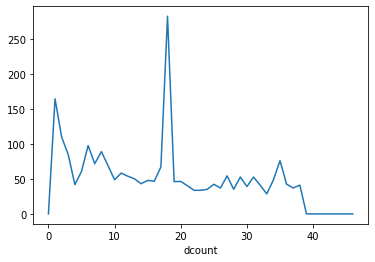

In [24]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

In [25]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000
